In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import torch.nn.init as init

import torch.utils.data as Data
import torchvision.datasets as dset
from torchvision import transforms

In [2]:
DOWNLOAD_CIFAR10 = False

if not(os.path.exists('./cifar10/')) or not os.listdir('./cifar10/'):
    # not cifar10 dir or cifar10 is empyt dir
    DOWNLOAD_CIFAR10 = True

trans = transforms.Compose([transforms.Grayscale(),transforms.ToTensor()])
train_set = dset.CIFAR10('./cifar10', train=True, transform=trans, download=DOWNLOAD_CIFAR10)

In [3]:
gray_scaled_train = np.dot(train_set.train_data[...,:3], [0.299, 0.587, 0.114])

Train set shape: (50000, 32, 32)


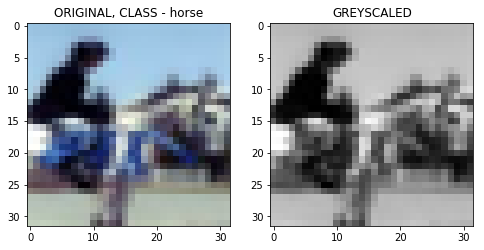

In [4]:
print('Train set shape:', gray_scaled_train.shape) # (50000, 32, 32)
label_names = ['airplane', 'automobile', 'bird', 
               'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

ri = np.random.randint(0, len(train_set), 1)[0]

fig = plt.figure(figsize=(8,16))
ax = fig.add_subplot(121)
ax.set_title('ORIGINAL, CLASS - '+label_names[train_set.train_labels[ri]])
plt.imshow(train_set.train_data[ri])
ax2 = fig.add_subplot(122)
ax2.set_title('GREYSCALED')
plt.imshow(gray_scaled_train[ri], cmap=plt.get_cmap('gray'))
plt.show()

In [5]:
BATCH_SIZE = 80

train_loader = Data.DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)

# Probabalistic VAE model:

## $p(x|\theta_{dec},z) = \mathcal{N}(x|\theta_{dec}^0(z), \theta_{dec}^1(z));$

## $q(z|\theta_{enc}, x) = \mathcal{N}(z|\theta_{enc}^0(x), \theta_{enc}^1(x));$

## $q_{\text{prior}}(z) = \mathcal{N}(z|0, I_d);$

## $\mathcal{L}_V(\theta_{enc}, \theta_{dec}) = \mathbb{E}_{q(\theta_{enc},x)}log\ p(x|\theta_{dec},z) - \mathbb{D}_{KL}(q(\theta_{enc},x)\| q_{\text{prior}}(z)) \rightarrow max_{\theta_{enc}, \theta_{dec}};$

## $\widetilde{\mathcal{L}_V}(\theta_{enc}, \theta_{dec}) = 0.5\frac{N}{M}\sum_{i=1}^M(ln(\theta_{dec}^1) + 
\frac{(x-\theta_{dec}^0))}{}$

In [16]:
class SimpleVAE(nn.Module):
    def __init__(self, embed_dim):
        """
        :param embed_dim: dimension of the hidden space, integer
        """
        super(SimpleVAE, self).__init__()
        self.embed_dim = embed_dim
        
        # encoding
        self.enc2med = nn.Linear(32*32, 512)
        self.med2mu_enc = nn.Linear(512, embed_dim)
        self.med2log_var_enc = nn.Linear(512, embed_dim)
        
        # decoding
        self.sample2med = nn.Linear(embed_dim, 512)
        self.med2mu_dec = nn.Linear(512, 32*32)
        self.med2log_var_dec = nn.Linear(512, 32*32)
        
        self.init_weights()
    
    def encode(self, x):
        """
        Retrieves hidden distribution params from the input image
        
        :param x: inputs, Variable of shape (batch_size, 32, 32)
        :return: mean and log_std for the hidden normal distribution, 
        two Variables of shapes (batch_size, embed_dim)
        """
        flattened = x.view(x.size()[0],-1)
        med = F.relu(self.enc2med(flattened))
        return self.med2mu_enc(med), self.med2log_var_enc(med)
    
    def decode(self, z):
        """
        Decodes image distribution params from the sampled hidden state
        
        :param z: inputs, Variable of shape (batch_size, embed_dim)
        :return: mean and log_std for the image normal distribution,
        two Variables of shapes (batch_size, 32, 32)
        """
        med = F.relu(self.sample2med(z))
        mu_dec = self.med2mu_dec(med)
        log_var_dec = self.med2log_var_dec(med)
        
        mu_dec = mu_dec.view(mu_dec.size()[0], 32, 32)
        log_var_dec = log_var_dec.view(log_var_dec.size()[0], 32, 32)
        return mu_dec, log_var_dec
    
    def reparametrize(self, mu, log_var):
        """
        Performs reparametrization trick to sample data
        
        :param mu: mean of the desired distribution, Variable of shape (batch_size, embed_dim)
        :param log_var: log_std of the desired distribution, 
        Variable of shape (batch_size, embed_dim)
        :return: samples, Variable of shape (batch_size, embed_dim)
        """
        standard_normal = Normal(torch.zeros(mu.size()[0], self.embed_dim), 
                                      torch.ones(mu.size()[0], self.embed_dim))
        if torch.cuda.is_available():
            r = Variable(standard_normal.sample().cuda(), requires_grad=False)
        else:
            r = Variable(standard_normal.sample(), requires_grad=False)
        
        return r * torch.exp(0.5 * log_var) + mu
    
    def forward(self, x):
        """
        Encodes input to get mean and std of hidden representations,
        and then decodes a sample from them
        
        :param x: inputs, Variable of shape (batch_size, 32, 32)
        :return: post-processed mean and log_std for the image normal distribution,
        two Variables of shapes (batch_size, 32, 32)
        """
        self.mu_enc, self.log_var_enc = self.encode(x)
        
        sample_z = self.reparametrize(self.mu_enc, self.log_var_enc)
        
        self.mu_dec, self.log_var_dec = self.decode(sample_z)
        
        return F.sigmoid(self.mu_dec), F.sigmoid(self.log_var_dec)
    
    def vae_loss(self, prediction, log_dispersion, target, tau):
        """
        Computes reconstruction loss, given prediction and target.
        IMPORTANT! Assumes that the prediction was already fed through the forward
        and self.mu_enc, self.log_var_enc, self.log_var_dec stores relevant values
        
        :param prediction: reconstructed image, Variable of shape (batch_size, 32, 32)
        :param log_dispersion: per-pixel log of dispersion, Variable of shape (batch_size, 32, 32)
        :param target: ground-truth image, Variable of shape (batch_size, 32, 32)
        :param tau: warm-start weight, float Variabe of shape (1,) 
        :return: averaged accross batches loss, float Variable of shape (1,)
        """
        est_x = prediction.view(prediction.size()[0],-1)
        est_log_sigma = log_dispersion.view(log_dispersion.size()[0],-1)
        true_x = target.view(target.size()[0],-1)
        
        l2_loss = 0.5 * torch.sum((est_x - true_x)**2/est_log_sigma.exp(), dim=1)
        
        dec_reg = 0.5 * torch.sum(est_log_sigma, dim=1)
        
        enc_reg = 0.5 * torch.sum(self.mu_enc**2 + self.log_var_enc.exp() - self.log_var_enc - 1, dim=1)
        
        return torch.mean(l2_loss + dec_reg + enc_reg * tau)
    
    def generate(self, z):
        """
        Generates an example
        
        :param z: hidden sample, Variable of shape (embed_dim,)
        :return: generated image, Variable of shape (32, 32)
        """
        return self.decode(z)
    
    def init_weights(self):
        """
        Initialize weights of the model
        """
        relu_gain = init.calculate_gain('relu')
        
        init.xavier_uniform(self.enc2med.weight, relu_gain)
        init.xavier_uniform(self.med2mu_enc.weight)
        init.xavier_uniform(self.med2log_var_enc.weight)
        
        init.xavier_uniform(self.sample2med.weight, relu_gain)
        init.xavier_uniform(self.med2mu_dec.weight)
        init.xavier_uniform(self.med2log_var_dec.weight)

In [17]:
autoencoder = SimpleVAE(24)

optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

if torch.cuda.is_available():
    print('using cuda...')
    autoencoder = autoencoder.cuda()

In [18]:
def dynamic_tau(epoch):
    # warm start condition
    tau = 0
    if epoch < 5:
        tau = 0
    elif epoch < 20:
        tau = (epoch-10)/10
    elif epoch >= 20:
        tau = 1
    return tau

In [19]:
N_EPOCHS = 10

epoch_loss = []
avg_loss = 0

for epoch in range(N_EPOCHS):
    print('-'*10)
    print('EPOCH:', epoch)
    avg_loss = 0
    ctau = dynamic_tau(epoch)
    
    for batch_ix, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        if torch.cuda.is_available():
            normed_x, target = Variable(x.cuda()), Variable(target.cuda())
        else:
            normed_x, target = Variable(x), Variable(target)
        
        out = autoencoder(normed_x)
        loss = autoencoder.vae_loss(out[0], out[1], normed_x, ctau)
        
        avg_loss += loss.data[0]
        loss.backward()
        optimizer.step()
    
    print('EPOCH LOSS:', avg_loss)
    epoch_loss += [avg_loss]

----------
EPOCH: 0
EPOCH LOSS: 8888.773612976074
----------
EPOCH: 1


KeyboardInterrupt: 

In [100]:
for batch_ix, (x, target) in enumerate(train_loader):
    if batch_ix == 1:
        break
    
    normed_x, target = Variable(x), Variable(target)
        
    out = autoencoder(normed_x)
    
    loss = autoencoder.vae_loss(out, normed_x)
    
    ex_out = out.data[0,:,:].numpy()
    ex_x = normed_x.data[0,0,:,:].numpy()
    ex_target = target.data[0]
    print(loss.data[0])

5.218120574951172


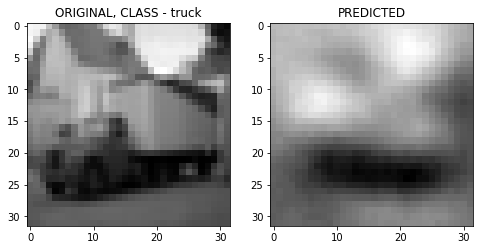

In [101]:
fig = plt.figure(figsize=(8,16))
ax = fig.add_subplot(121)
ax.set_title('ORIGINAL, CLASS - '+label_names[ex_target])
plt.imshow(ex_x, cmap='gray')
ax2 = fig.add_subplot(122)
ax2.set_title('PREDICTED')
plt.imshow(ex_out, cmap='gray')
plt.show()